<h1><center>Datos Atípicos</center></h1>
<h3><center>Yerimi Gamboa Caballero (2161953)</center></h3>
<h4><center>Universidad Industrial de Santander</center></h4>

Los datos atípicos, son mediciones que difieren significativamente del patrón general de los datos que pueden ser consecuencia de errores en la medición y la variabilidad intrínseca o aleatoria. Se sabe que tienen un impacto directo en los análisis estadísticos posteriores que se realicen, de no ser detectados y manejados adecuadamente.

## Detección de datos atípicos usando Pyod.

#### Algoritmos seleccionados de la librería Pyod

La elección de estos algoritmos se basa en la presencia de ciertos parámetros que, junto al atributo `decision_scores_`, permiten establecer un criterio para la toma de decisiones. En particular, se buscó una similitud con el concepto de **"criterio de inercia"**. La inercia se refiere a la propiedad de resistencia al cambio o falta de variaciones significativas en el comportamiento de un valor en relación con su contexto histórico. Específicamente, en el contexto de la detección de valores periféricos o atípicos, la **inercia** se utiliza para describir la tendencia de un valor atípico a mantener una constancia relativa frente a circunstancias cambiantes o en comparación con los valores más típicos en el conjunto de datos. Esta característica puede sugerir que un valor es auténticamente atípico y merece una atención especial en el análisis, ya que su comportamiento difiere significativamente de lo que se considera normal o esperado en ese contexto. 

La matriz de puntuaciones de decisión, denominada `decision_scores_`, describe el grado de atipicidad de un dato en el conjunto de entrenamiento. Una característica clave es que valores más altos en estas puntuaciones indican mayor anormalidad. Esto significa que los datos con puntuaciones más altas tienden a ser considerados como valores atípicos, ya que se desvían significativamente del comportamiento típico del conjunto de datos. En el contexto de esta matriz de puntuaciones de decisión, los algoritmos seleccionados buscan identificar y etiquetar los valores que presentan una puntuación alta, lo que sugiere una mayor probabilidad de ser atípicos. A continuación, se proporciona una descripción más detallada de los algoritmos seleccionados y cómo interactúan con los parámetros de entrada:

- **Algoritmos con parametro de entrada n_neighbors**

    Estos algoritmos utilizan el número de vecinos n_neighbors como un parámetro para realizar consultas de vecinos más cercanos. Los vecinos más cercanos son aquellos puntos de datos que están más próximos en función de alguna medida de distancia. Estos algoritmos evalúan cómo los puntos se relacionan con sus vecinos cercanos para determinar si son atípicos o no. Cada algoritmo se basa en un enfoque particular para medir esta relación:
    <br>
    
    - _k-Nearest Neighbors Detector (kNN)_: Detecta atipicidad en función de la distancia a los k vecinos más cercanos.
    
    - _Factor atípico local (LOF)_: Mide la desviación de densidad de un punto en comparación con sus vecinos, detectando densidades significativamente diferentes.


- **Algoritmos con parametro de entrada n_clusters**

    Estos algoritmos crean grupos y centroides en función del número n_clusters. Los valores atípicos se identifican mediante la desviación de la densidad de un punto respecto a su grupo de pertenencia:
    <br>

    - _Clustering Based Local Outlier Factor (CBLOF)_: Evalúa atipicidad basándose en la diferencia de densidad de un punto respecto a su grupo.
    
- **Algoritmos con parametro de entrada n_estimators**

     Estos algoritmos generan grupos y centroides según el número n_estimators especificado:
     <br>

    - _IsolationForest Outlier Detector (IForest)_: Detecta valores atípicos mediante la construcción de árboles de aislamiento.
    - _Isolation-based anomaly detection using nearest-neighbor ensembles (INNE)_: Detecta valores atípicos basándose en el aislamiento y conjuntos de vecinos más cercanos.


### Procesamiento de datos

- Carga de conjuntos de datos.
- Validación de datos: Asegúrate de que los datos estén completos y coherentes.
- Normalización.

In [37]:
# Se cargan las librerias a usar.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# Carga de datos
data = pd.read_csv('data_las_ferias_clean.csv', delimiter = ',')
data['ts'] = pd.to_datetime(data['ts'], format='%d-%m-%Y %H:%M', utc=False)
data.set_index('ts', inplace=True)

In [39]:
# Datas de material particulado
data_pm10 = data.iloc[:,0:1] 
data_pm25 = data.iloc[:,1:2]

In [40]:
#Validación de Datos: la cantidad de valores faltantes 
missing_values_pm25 = data_pm25.isnull().sum()
print(f'Numero de de datos Nan en data_{missing_values_pm25}')

missing_values_pm10 = data_pm10.isnull().sum()
print(f'Numero de de datos Nan en data_{missing_values_pm10}')

Numero de de datos Nan en data_pm2.5    685
dtype: int64
Numero de de datos Nan en data_pm10    1561
dtype: int64


In [41]:
# Eliminar filas que contienen valores NaN: Eliminacion de valores faltantes 
data_pm25 = data_pm25.dropna(axis=0)
data_pm10 = data_pm10.dropna(axis=0)

### Algoritmos con parametro de entrada n_neighbors


In [42]:
#se cargan los modelos 
from pyod.models.iforest import IForest #1 -->
from pyod.models.inne import INNE #1 -->
# n_neighbors 
from pyod.models.knn import KNN #1 -->
from pyod.models.lof import LOF #1 -->

from pyod.models.cblof import CBLOF # 3-->



El criterio de decisión para estos algoritmos implica determinar el valor de `n_neighbors` en el momento en que se produce un cambio sustancial en la inercia. En este contexto, la inercia se define como la trayectoria que forman los puntajes de decisión (`decision_scores_`), ya sean máximos o mínimos, mientras se iteran a través de un rango de valores posibles de `n_neighbors`.

In [31]:
#Invercia
def calcular_inercias(modelos, data, parametro_variar,a,b):
    inercias = []
    for modelo in modelos:
        score_max = []
        for i in range(a,b):
            dec = modelo(**{parametro_variar: i})  # Usar diccionario para pasar el parámetro
            dec.fit(data)
            score_max.append(dec.decision_scores_.max())
        
        inercias.append(score_max)
    return inercias

In [35]:
inercia_ne_pm25 = calcular_inercias([IForest,INNE], data_pm25, 'n_estimators', 10, 50)
inercia_nn_pm25 = calcular_inercias([KNN, LOF], data_pm25, 'n_neighbors', 10, 50)
inercia_nc_pm25 = calcular_inercias([CBLOF], data_pm25, 'n_clusters', 10, 50)

c:\Users\YERIMIGAMBOA\.conda\envs\trabajo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YERIMIGAMBOA\.conda\envs\trabajo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YERIMIGAMBOA\.conda\envs\trabajo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\YERIMIGAMBOA\.conda\envs\trabajo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

In [39]:
len(inercia_ne_pm25[0])

40

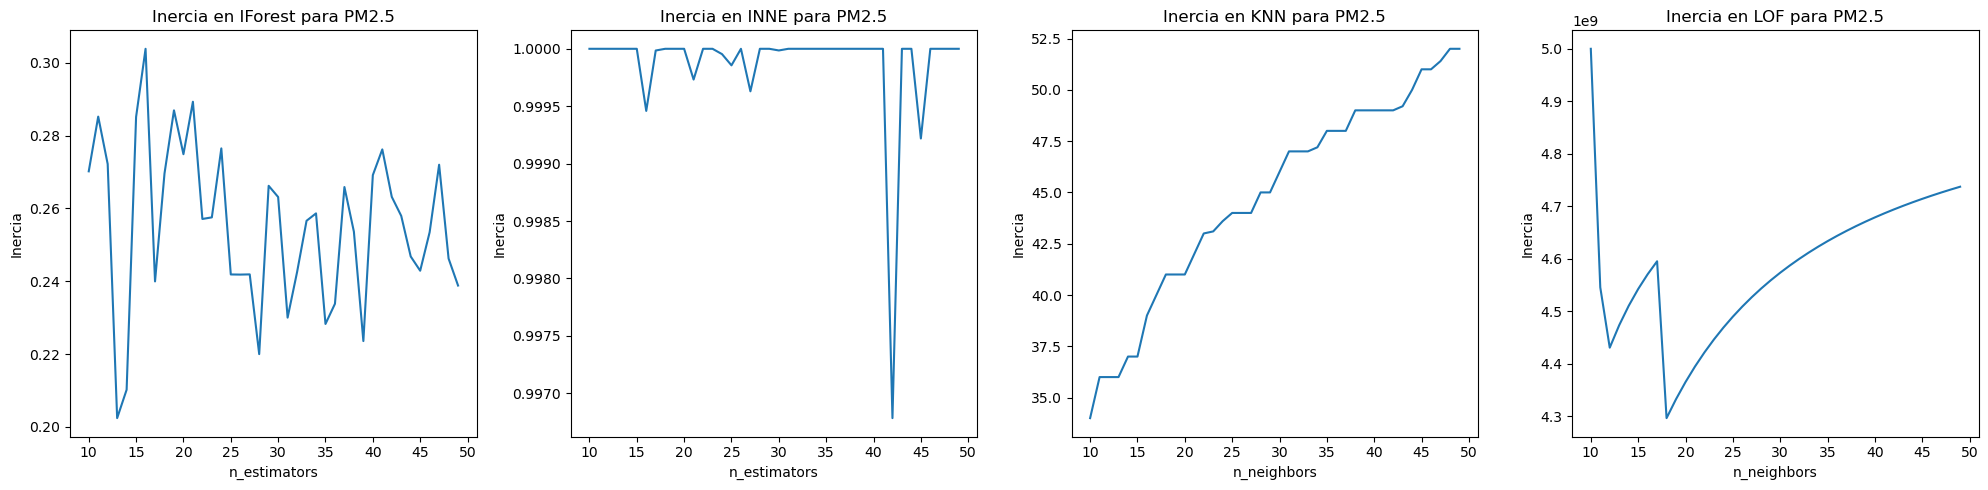

In [43]:

# Crear la figura de inercias
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].plot(np.arange(10, 50, 1), inercia_ne_pm25[0])
axs[0].set_title('Inercia en IForest para PM2.5')
axs[0].set_xlabel('n_estimators')
axs[0].set_ylabel('Inercia')

axs[1].plot(np.arange(10, 50, 1), inercia_ne_pm25[1])
axs[1].set_title('Inercia en INNE para PM2.5')
axs[1].set_xlabel('n_estimators')
axs[1].set_ylabel('Inercia')

axs[2].plot(np.arange(10, 50, 1), inercia_nn_pm25[0])
axs[2].set_title('Inercia en KNN para PM2.5')
axs[2].set_xlabel('n_neighbors')
axs[2].set_ylabel('Inercia')

axs[3].plot(np.arange(10, 50, 1),  inercia_nn_pm25[1])
axs[3].set_title('Inercia en LOF para PM2.5')
axs[3].set_xlabel('n_neighbors')
axs[3].set_ylabel('Inercia')

# Ajustar los espacios entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

In [106]:
detector_1 = IForest()
detector_1.fit(data_pm10 )
detector_2 = INNE()
detector_2.fit(data_pm10 )
detector_3 = KNN()
detector_3.fit(data_pm10 )
detector_4 = LOF()
detector_4.fit(data_pm10 )
detector_5 = CBLOF()
detector_5.fit(data_pm10 )

c:\Users\YERIMIGAMBOA\.conda\envs\trabajo\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=8, n_jobs=None, random_state=None,
   use_weights=False)

In [107]:
def detect_and_select_outliers(detector, data):
    """
    Detecta valores atípicos/anomalías utilizando un detector y selecciona los datos atípicos del DataFrame.
    
    Args:
        detector: Objeto de detección de anomalías (por ejemplo, un modelo entrenado).
        data: DataFrame que contiene los datos a analizar.
        
    Returns:
        data_outliers: DataFrame que contiene solo los valores atípicos/anomalías del DataFrame original.
    """
    previsiones = detector.labels_
    outliers_indices = [i for i, label in enumerate(previsiones) if label == 1]
    data_outliers = data.iloc[outliers_indices, :]
    return data_outliers

In [113]:
data_outliers_IForest = detect_and_select_outliers(detector_1, data_pm10 )
data_outliers_INNE = detect_and_select_outliers(detector_2, data_pm10 )
data_outliers_KNN = detect_and_select_outliers(detector_3, data_pm10 )
data_outliers_LOF = detect_and_select_outliers(detector_4, data_pm10 )
data_outliers_CBLOF = detect_and_select_outliers(detector_5, data_pm10 )

In [114]:
#Se muestra de la cantidad total de datos, la cantidad de valores no outliers y la cantidad de posibles outliers.
print(np.unique(detector_1.labels_, return_counts = True))
print(np.unique(detector_2.labels_, return_counts = True))
print(np.unique(detector_3.labels_, return_counts = True))
print(np.unique(detector_4.labels_, return_counts = True))
print(np.unique(detector_5.labels_, return_counts = True))

(array([0, 1]), array([17131,  1900], dtype=int64))
(array([0, 1]), array([17143,  1888], dtype=int64))
(array([0, 1]), array([18563,   468], dtype=int64))
(array([0, 1]), array([17908,  1123], dtype=int64))
(array([0, 1]), array([17143,  1888], dtype=int64))


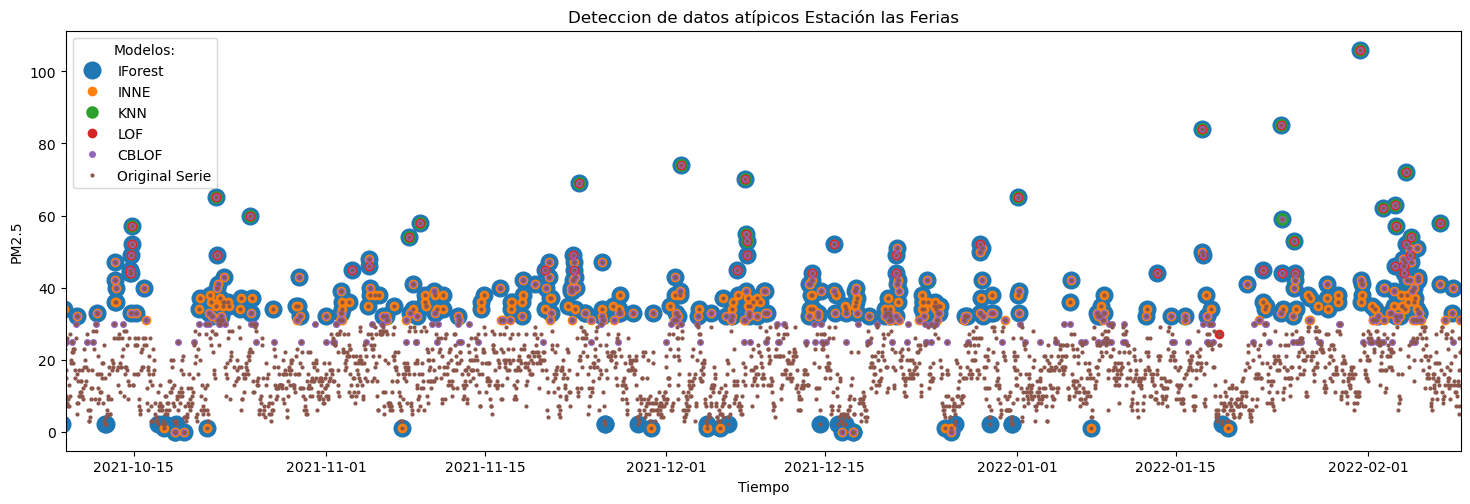

In [105]:
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.plot(data_outliers_IForest, 'o', label = 'IForest',markersize=12)
plt.plot(data_outliers_INNE, 'o', label = 'INNE',markersize=6)
plt.plot(data_outliers_KNN, 'o', label = 'KNN',markersize=8)
plt.plot(data_outliers_LOF, 'o', label = 'LOF',markersize=6)
plt.plot(data_outliers_CBLOF,'o',label = 'CBLOF',markersize=4)
plt.plot(data_pm25,'o', markersize=2, label = 'Original Serie')
plt.legend(title="Modelos:")
plt.xlim(pd.Timestamp('2021-10-09 00:00:00'), pd.Timestamp('2022-02-09 04:00:00'))

plt.title('Deteccion de datos atípicos Estación las Ferias')
plt.xlabel('Tiempo')
plt.ylabel('PM2.5')
plt.show()

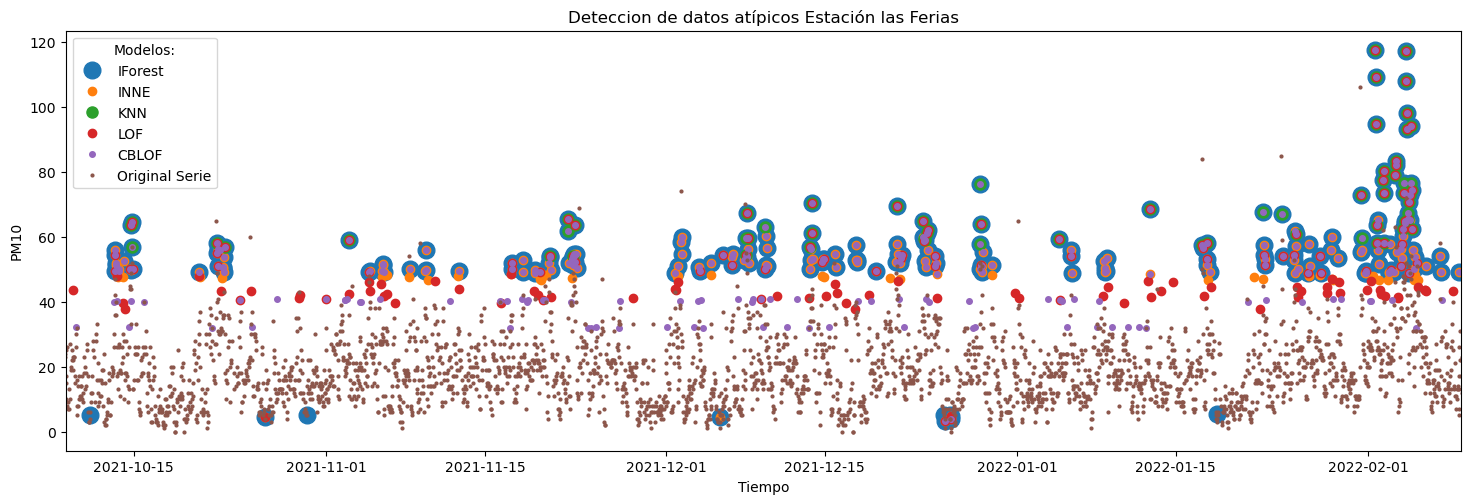

In [115]:
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.plot(data_outliers_IForest, 'o', label = 'IForest',markersize=12)
plt.plot(data_outliers_INNE, 'o', label = 'INNE',markersize=6)
plt.plot(data_outliers_KNN, 'o', label = 'KNN',markersize=8)
plt.plot(data_outliers_LOF, 'o', label = 'LOF',markersize=6)
plt.plot(data_outliers_CBLOF,'o',label = 'CBLOF',markersize=4)
plt.plot(data_pm25,'o', markersize=2, label = 'Original Serie')
plt.legend(title="Modelos:")
plt.xlim(pd.Timestamp('2021-10-09 00:00:00'), pd.Timestamp('2022-02-09 04:00:00'))

plt.title('Deteccion de datos atípicos Estación las Ferias')
plt.xlabel('Tiempo')
plt.ylabel('PM10')
plt.show()

In [116]:
import pandas as pd

# Definir la función de contar índices iguales
def contar_indices_iguales(df1, df2):
    indices_df1 = set(df1.index)
    indices_df2 = set(df2.index)
    indices_comunes = indices_df1.intersection(indices_df2)
    return len(indices_comunes)

# Lista de DataFrames
data_frames = [data_outliers_IForest, data_outliers_INNE, data_outliers_KNN, data_outliers_LOF, data_outliers_CBLOF]

# Contar índices iguales entre los DataFrames
num_indices_iguales = []
for i in range(len(data_frames)):
    for j in range(i+1, len(data_frames)):
        indices_iguales = contar_indices_iguales(data_frames[i], data_frames[j])
        num_indices_iguales.append(indices_iguales)
        print(f"DataFrames {i} y {j} comparten {indices_iguales} índices iguales.")

# Suma total de índices iguales
total_indices_iguales = sum(num_indices_iguales)
print(f"En total, los DataFrames comparten {total_indices_iguales} índices iguales.")


DataFrames 0 y 1 comparten 1630 índices iguales.
DataFrames 0 y 2 comparten 467 índices iguales.
DataFrames 0 y 3 comparten 724 índices iguales.
DataFrames 0 y 4 comparten 1471 índices iguales.
DataFrames 1 y 2 comparten 467 índices iguales.
DataFrames 1 y 3 comparten 756 índices iguales.
DataFrames 1 y 4 comparten 1484 índices iguales.
DataFrames 2 y 3 comparten 344 índices iguales.
DataFrames 2 y 4 comparten 467 índices iguales.
DataFrames 3 y 4 comparten 676 índices iguales.
En total, los DataFrames comparten 8486 índices iguales.


In [117]:
import pandas as pd

# Definir la función de contar índices iguales
def contar_indices_iguales(df1, df2):
    indices_df1 = set(df1.index)
    indices_df2 = set(df2.index)
    indices_comunes = indices_df1.intersection(indices_df2)
    return indices_comunes

# Lista de DataFrames
data_frames = [data_outliers_IForest, data_outliers_INNE, data_outliers_KNN, data_outliers_LOF, data_outliers_CBLOF]

# Crear un DataFrame para almacenar los índices compartidos
indice_compartido_df = pd.DataFrame(index=range(len(data_frames)), columns=range(len(data_frames)))

# Llenar el DataFrame con la cantidad de índices compartidos
for i in range(len(data_frames)):
    for j in range(len(data_frames)):
        if i != j:
            indices_iguales = contar_indices_iguales(data_frames[i], data_frames[j])
            indice_compartido_df.at[i, j] = len(indices_iguales)
        else:
            indice_compartido_df.at[i, j] = 0

# Renombrar filas y columnas para representar los nombres de los DataFrames
data_frame_nombres = ["IForest", "INNE", "KNN", "LOF", "CBLOF"]
indice_compartido_df.index = data_frame_nombres
indice_compartido_df.columns = data_frame_nombres

print("Tabla de índices compartidos:")
print(indice_compartido_df)


Tabla de índices compartidos:
        IForest  INNE  KNN  LOF CBLOF
IForest       0  1630  467  724  1471
INNE       1630     0  467  756  1484
KNN         467   467    0  344   467
LOF         724   756  344    0   676
CBLOF      1471  1484  467  676     0
